# Clustering from SafeGraph data

[Index](0-index.ipynb)

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import h5py
import scipy
import sklearn.cluster

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
plt.rcParams['svg.fonttype'] = 'none'
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as sch


from IPython.display import HTML
from IPython.display import Image

In [3]:
datadir = Path('../data')
if not datadir.is_dir():
    raise ValueError("Data dir doesn'nt exist!")

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile_init = datadir / 'safegraph_analysis_start.hdf5'
resfile = resdir / 'safegraph_analysis.hdf5'
shutil.copy(resfile_init, resfile)

complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 858 entries.


In [6]:
exts = ['.png', '.svg']
dpi=300

## Functions

In [7]:
def make_dict_serializable(mydict):
    for k, v in mydict.items():
        if isinstance(v, dict):
            make_dict_serializable(v)
        else:
            if type(v) == np.ndarray:
                mydict[k]= v.tolist()                                      
            elif type(v) == pd.Int64Index:
                mydict[k]=v.tolist()
            elif type(v) == np.float_:
                mydict[k]=float(v)
            elif type(v) == np.int_:
                mydict[k]=int(v)
            elif type(v) == datetime.datetime:
                mydict[k]=v.strftime('%Y-%m-%d')
    return mydict

## Preliminary checks
Extract SafeGraph Open Census Data if it is not yet.

In [8]:
import tarfile

In [17]:
if not (datadir / 'safegraph_open_census_data').is_dir():
    fpath = datadir / 'safegraph_open_census_data.tgz'
    if not fpath.is_file():
        raise ValueError("Missing SafeGraph open census data!")

    with tarfile.open(fpath, "r") as tar:
        tar.extractall(path=datadir)

## Construct index

In [8]:
geofile = datadir / 'safegraph_open_census_data' / 'geometry' / 'cbg.geojson'
if not geofile.is_file():
    raise ValueError("Geo file doesn't exist!")

In [9]:
geo = gpd.read_file(geofile).astype({'CensusBlockGroup': 'int64'})

In [10]:
geo.set_index('CensusBlockGroup', inplace=True)
geo

,StateFIPS,CountyFIPS,TractCode,BlockGroup,State,County,ClassCode,geometry
CensusBlockGroup,,,,,,,,
10810416001,01,081,041600,1,AL,Lee County,H1,"MULTIPOLYGON (((-85.37282 32.63424, -85.37275 ..."
10810416002,01,081,041600,2,AL,Lee County,H1,"MULTIPOLYGON (((-85.38346 32.64838, -85.38301 ..."
10810417004,01,081,041700,4,AL,Lee County,H1,"MULTIPOLYGON (((-85.37139 32.60139, -85.37138 ..."
10730111074,01,073,011107,4,AL,Jefferson County,H1,"MULTIPOLYGON (((-86.64797 33.59205, -86.64771 ..."
10730111084,01,073,011108,4,AL,Jefferson County,H1,"MULTIPOLYGON (((-86.65206 33.59869, -86.65204 ..."
...,...,...,...,...,...,...,...,...
720851902012,72,085,190201,2,PR,Las Piedras Municipio,H1,"MULTIPOLYGON (((-65.86850 18.18426, -65.86836 ..."
720851902013,72,085,190201,3,PR,Las Piedras Municipio,H1,"MULTIPOLYGON (((-65.87053 18.17034, -65.87040 ..."
720851902021,72,085,190202,1,PR,Las Piedras Municipio,H1,"MULTIPOLYGON (((-65.87678 18.17519, -65.87656 ..."


In [11]:
figdir = Path('..') / 'figures' / '1-clustering'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

In [12]:
XY = geo.representative_point()
indices = np.arange(len(geo.index))
XY = np.array([[x.x,x.y] for x in XY.to_numpy()])
X,Y = XY.T

norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = cm.rainbow

colors = cmap(norm(indices))

fig = plt.figure(figsize=(4,3),dpi=300)
ax = fig.gca()
npts = len(X)
idump = 5
for i in np.arange(npts)[::idump]:
#     if i % idump == 0:
#         print(f"{i} / {npts}")
    x = X[i]
    y = Y[i]
    circle = plt.Circle((x,y), 0.5, color=colors[i], alpha=0.5, lw=0)
    ax.add_patch(circle)
    
xmin = np.min(X)
xmax = np.max(X)
ymin = np.min(Y)
ymax = np.max(Y)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
for lab in 'left', 'right', 'bottom', 'top':
    ax.spines[lab].set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
cax = fig.add_axes(rect=[0.98,0.1,0.02,0.7])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, label='Matrix index', extendfrac='auto')

fname = 'clusters_before_ordering'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')


Written file: ../figures/1-clustering/clusters_before_ordering.png
Written file: ../figures/1-clustering/clusters_before_ordering.svg


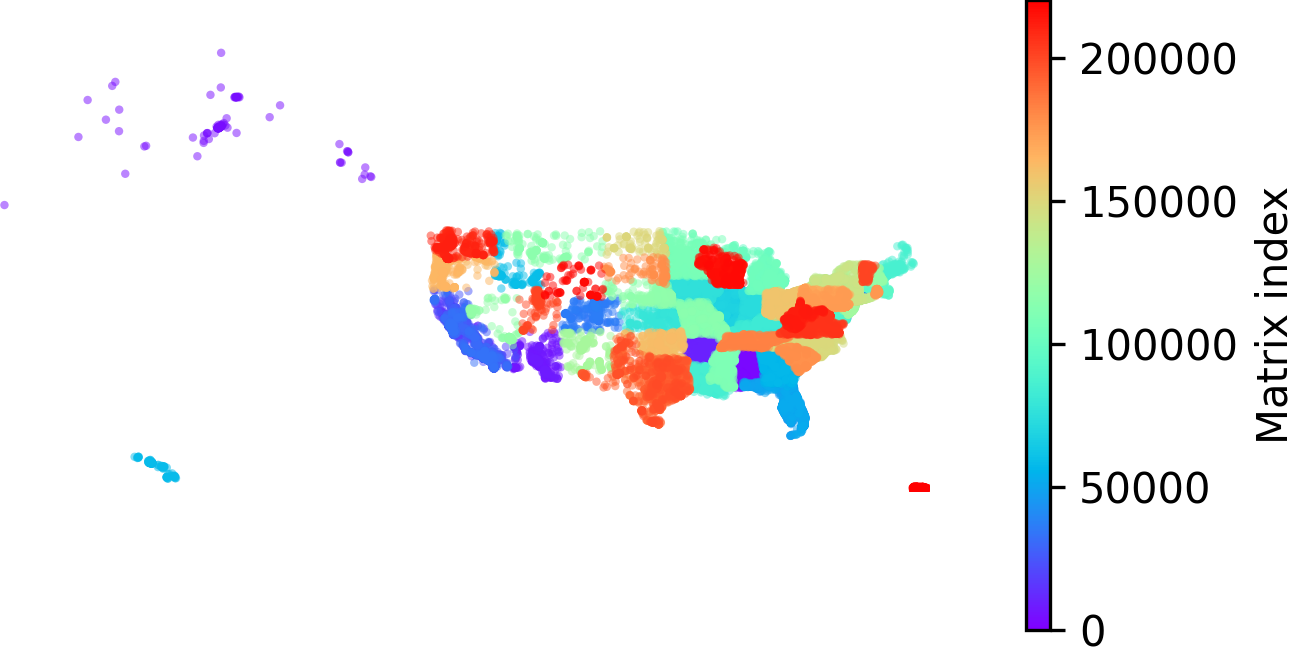

In [13]:
fname = 'clusters_before_ordering'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Clustering

### K-means clustering -- KMeans()

In [14]:
# UNCOMMENT TO RECOMPUTE
# n_clusters = 2**10
# np.random.seed(123)

# clustering = sklearn.cluster.KMeans(n_clusters=n_clusters, algorithm="full")
# res = clustering.fit(XY)

# cluster_centers = res.cluster_centers_
# data_labels = res.predict(XY)
# data_labels = pd.DataFrame(data_labels, index=geo.index)
# data_labels.rename(columns={0: 'leaves'}, inplace=True)

### Re-order clusters using a hierarchichal clustering method

In [15]:
# UNCOMMENT TO RECOMPUTE
# XY = cluster_centers.copy()
# Z = sch.linkage(XY, method='average')
# Z = sch.optimal_leaf_ordering(Z, XY)

# key_base = Path("/clustering")
# with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
#     key = str(key_base / "cbgs_clusters")
#     store[key] = data_labels
    
#     key = str(key_base / "linkage_matrix")
#     store[key] = pd.DataFrame(data=Z)

In [16]:
# COMMENT TO RECOMPUTE
key_base = Path("/clustering")
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = str(key_base / "cbgs_clusters")
    data_labels = store[key]
    
    key = str(key_base / "linkage_matrix")
    Z = store[key].to_numpy()
    
    key = str(key_base / "clusters")
    cluster_centers = store[key].set_index('leaves').sort_index(axis=0).loc[:,['X','Y']].to_numpy()

In [17]:
leaves = sch.leaves_list(Z).astype('int64')

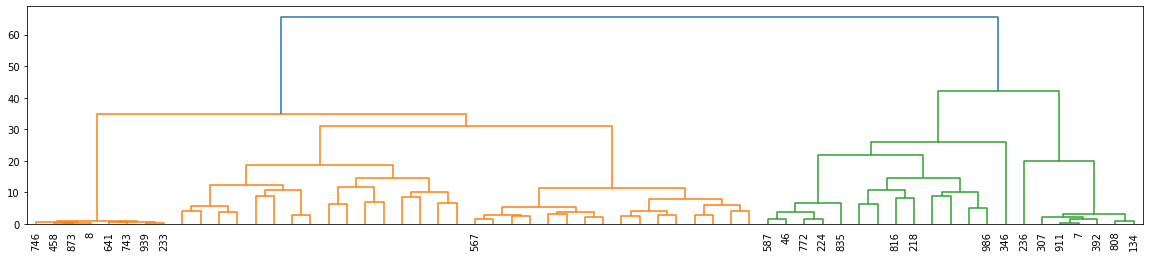

In [18]:
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
dendrogram(Z, truncate_mode='level', p=6, ax=ax, show_leaf_counts=False)
plt.xticks(rotation=90, fontsize='medium')
plt.show()

In [19]:
cluster_centers_ordered = cluster_centers[leaves]
X,Y = cluster_centers_ordered.T
npts = len(X)
indices = np.arange(npts)

norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = cm.rainbow

colors = cmap(norm(indices))

fig = plt.figure(figsize=(4,3),dpi=300)
ax = fig.gca()
for i in np.arange(npts):
#     if i % idump == 0:
#         print(f"{i} / {npts}")
    x = X[i]
    y = Y[i]
    circle = plt.Circle((x,y), 0.5, color=colors[i], alpha=0.5, lw=0)
    ax.add_patch(circle)
    
xmin = np.min(X)
xmax = np.max(X)
ymin = np.min(Y)
ymax = np.max(Y)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
for lab in 'left', 'right', 'bottom', 'top':
    ax.spines[lab].set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
cax = fig.add_axes(rect=[0.98,0.1,0.02,0.7])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, label='Matrix index', extendfrac='auto')

fname = 'clusters_after_ordering'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/1-clustering/clusters_after_ordering.png
Written file: ../figures/1-clustering/clusters_after_ordering.svg


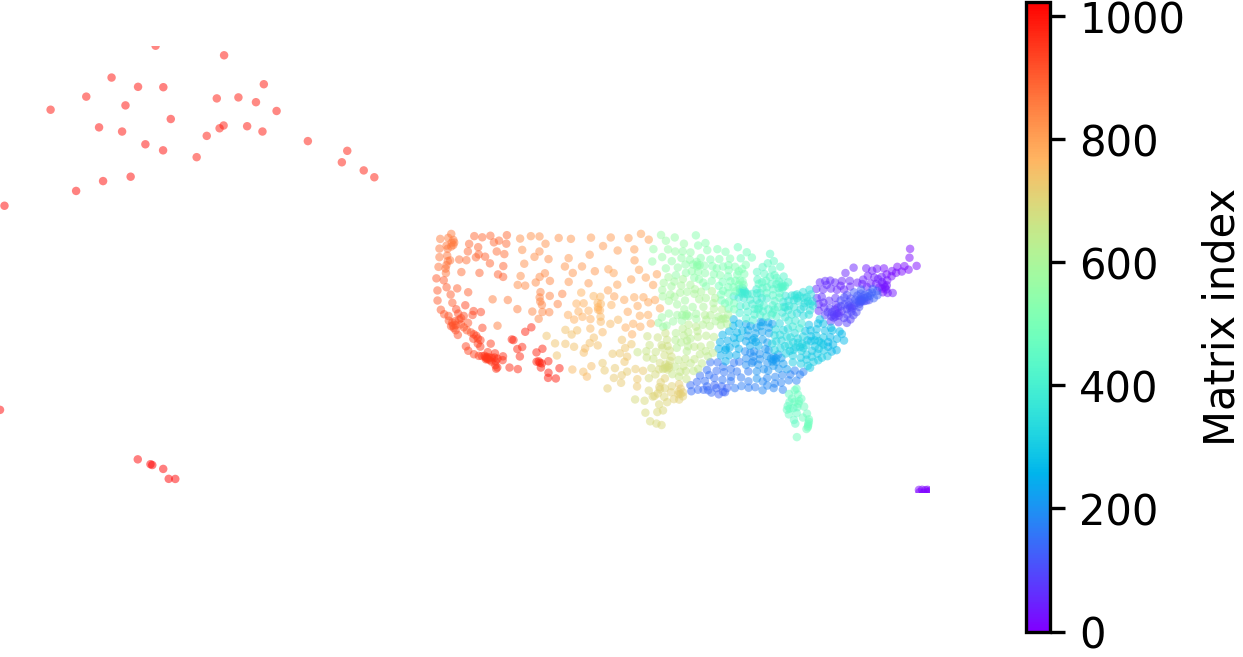

In [20]:
fname = 'clusters_after_ordering'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [21]:
groups = data_labels.groupby(['leaves']).groups
groups = [groups[i].tolist() for i in range(len(cluster_centers))]
groups_ordered = [groups[leaves[i]] for i in range(len(leaves))]

df = pd.DataFrame(data=cluster_centers_ordered, columns=['X', 'Y'])
df = pd.concat([df, pd.DataFrame(pd.Series(groups_ordered), columns=['cbg_clusters'])], axis=1)
df = pd.concat([df, pd.DataFrame(pd.Series(leaves), columns=['leaves'])], axis=1)

df

,X,Y,cbg_clusters,leaves
0,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",746
1,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",458
2,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",873
3,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",8
4,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",641
...,...,...,...,...
1019,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",911
1020,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",7
1021,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",392
1022,-155.865732,19.692965,"[150010216012, 150010214023, 150010216041, 150...",808


### Fill-in total population

In [23]:
columns = ['B01001e1']
cbg_data = pd.read_csv(datadir / 'safegraph_open_census_data' / 'data' / 'cbg_b01.csv').set_index('census_block_group').loc[:,columns]
cbg_data

,B01001e1
census_block_group,
10010201001,745
10010201002,1265
10010202001,960
10010202002,1236
10010203001,2364
...,...
721537506011,921
721537506012,2703
721537506013,1195


In [24]:
data_labels['population']= cbg_data.loc[data_labels.index]
data_labels

,leaves,population
CensusBlockGroup,,
10810416001,68,2434
10810416002,68,1136
10810417004,68,2589
10730111074,440,3952
10730111084,440,764
...,...,...
720851902012,746,447
720851902013,746,2281
720851902021,746,1229


In [25]:
pop = data_labels.groupby(by='leaves')['population'].sum().to_frame()
pop

,population
leaves,
0,1592498
1,582883
2,174688
3,195108
4,399160
...,...
1019,123493
1020,68224
1021,356071


In [26]:
df.reset_index(inplace=True)
df.set_index('leaves', inplace=True)
df.loc[pop.index,'population'] = pop['population']
df.reset_index(inplace=True)
df.set_index('index', inplace=True)
df

,leaves,X,Y,cbg_clusters,population
index,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598
...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290


In [27]:
df.loc[df['population'] == 0]

,leaves,X,Y,cbg_clusters,population
index,,,,,
1017,236,-175.828603,27.854941,[150039812001],0


So there is one empty community once the CBGs are clustered using SafeGraph data.

### Write final clustering information

In [28]:
key_base = Path("/clustering")
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = str(key_base / "clusters")
    store[key] = df

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3441: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cbg_clusters'], dtype='object')]

  exec(code_obj, self.user_global_ns, self.user_ns)


Export to csv

In [29]:
expdir = resdir / 'csv'
if not expdir.is_dir():
    expdir.mkdir()

In [30]:
fname = 'clustering.csv'
df.to_csv(expdir / fname)